# Chest Xray Classification with PyHealth
We will use PyHealth to analyze chest X-ray images and classify them into various chest diseases.

## Environment Setup


In [ ]:
!pip uninstall -y numpy pandas
!pip install numpy==1.23.5 pandas==1.5.3


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, 

In [ ]:
!pip install mne pandarallel rdkit transformers

In [ ]:
!rm -rf PyHealth
!git clone https://github.com/sunlabuiuc/PyHealth.git


Cloning into 'PyHealth'...
remote: Enumerating objects: 8807, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8807 (delta 0), reused 0 (delta 0), pack-reused 8805 (from 2)
Receiving objects: 100% (8807/8807), 123.56 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (5759/5759), done.


In [ ]:
import sys
sys.path.append("./PyHealth")

## Download Data

Next, we will download the dataset containing COVID-19 data. This dataset includes chest X-ray images of normal cases, lung opacity, viral pneumonia, and COVID-19 patients. The fuul information about the dataset [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

This dataset is hosted on Google Cloud. Download Data Set

In [ ]:
!wget -N https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip

--2025-05-20 17:23:00--  https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 172.217.214.207, 142.251.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘archive.zip’ not modified on server. Omitting download.



In [ ]:
!unzip -q -o archive.zip

In [ ]:
!ls -1 COVID-19_Radiography_Dataset

COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
'Viral Pneumonia'
'Viral Pneumonia.metadata.xlsx'


Next, we will proceed with the chest X-ray classification task using PyHealth, following a five-stage pipeline.

## Step 1. Load Data in PyHealth

The initial step involves loading the data into PyHealth's internal structure. PyHealth will handle the dataset processing automatically.

In [ ]:
!pip install --upgrade pyhealth


In [ ]:
from pyhealth.datasets import COVID19CXRDataset, split_by_sample, get_dataloader
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from pyhealth.models import BaseModel
from pyhealth.datasets.sample_dataset import SampleBaseDataset
from pyhealth.trainer import Trainer
import torchvision.models as models
from PIL import Image
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F


/usr/local/lib/python3.11/dist-packages/pyhealth/trainer.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [ ]:
# Set the path to the root directory where the COVID-19 radiography dataset is stored
root = "/content/COVID-19_Radiography_Dataset"

# Construct the full path to the metadata CSV file by appending the filename to the root path
csv_path = root + "/covid19_cxr-metadata-pyhealth.csv"

# Initialize the COVID19CXRDataset object using the root path and the path to the metadata CSV file
base_dataset = COVID19CXRDataset(root=root, metadata_path=csv_path)


Once the data is loaded, we can perform simple queries on the dataset.

In [ ]:
base_dataset.stat()

Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


In [ ]:
base_dataset.patients[0]

{'path': '/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png',
 'url': 'https://sirm.org/category/senza-categoria/covid-19/',
 'label': 'COVID'}

## Step 2. Define the Task

The next step is to define the machine learning task. This step instructs the package to generate a list of samples with the desired features and labels based on the data for each individual patient. Please note that in this dataset, patient identification information is not available. Therefore, we will assume that each chest X-ray belongs to a unique patient.

For this dataset, PyHealth offers a default task specifically for chest X-ray classification. This task takes the image as input and aims to predict the chest diseases associated with it.

In [ ]:
base_dataset.default_task

COVID19CXRClassification(task_name='COVID19CXRClassification', input_schema={'path': 'image'}, output_schema={'label': 'label'})

In [ ]:
# Set up the default prediction task on the base dataset (e.g., classifying COVID-19 status) and store the resulting task-specific dataset
sample_dataset = base_dataset.set_task()

Here is an example of a single sample, represented as a dictionary. The dictionary contains keys for feature names, label names, and other metadata associated with the sample.

In [ ]:
sample_dataset[0]

{'path': tensor([[[0.7255, 0.1569, 0.0000,  ..., 0.0000, 0.0941, 0.5137],
          [0.2941, 0.0549, 0.0000,  ..., 0.0000, 0.0314, 0.1647],
          [0.0431, 0.0078, 0.0000,  ..., 0.0039, 0.0118, 0.0471],
          ...,
          [0.3059, 0.2431, 0.2667,  ..., 0.0118, 0.0510, 0.1059],
          [0.4078, 0.2902, 0.2941,  ..., 0.0039, 0.0902, 0.3255],
          [0.6118, 0.3529, 0.3059,  ..., 0.0039, 0.1765, 0.6549]]]),
 'url': 'https://sirm.org/category/senza-categoria/covid-19/',
 'label': 'COVID'}

In [ ]:
sample_dataset

We can also check the input and output schemas, which specify the data types of the features and labels.

In [ ]:
sample_dataset.input_schema

{'path': <pyhealth.datasets.featurizers.image.ImageFeaturizer at 0x7a9ae263c610>}

In [ ]:
sample_dataset.output_schema

{'label': ValueFeaturizer()}

Below, we plot the number of samples per classes, and visualize some samples.

In [ ]:
# Extract the 'label' field from each sample in the dataset and store them in a list
labels = [sample['label'] for sample in sample_dataset.samples]

# Create a sorted list of unique labels from the collected labels
unique_labels = sorted(set(labels))

# Create a dictionary that maps each label to a unique numeric ID (label → ID)
label2id = {label: idx for idx, label in enumerate(unique_labels)}

# Create a reverse mapping dictionary from ID to label (ID → label)
id2label = {idx: label for label, idx in label2id.items()}


defaultdict(<class 'int'>, {'COVID': 3616, 'Lung Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345})


<BarContainer object of 4 artists>

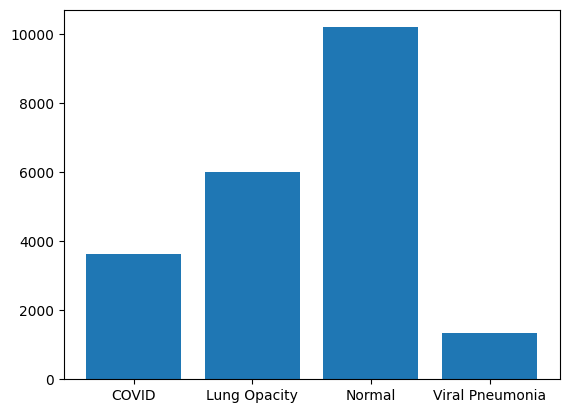

In [ ]:
# Import defaultdict from the collections module to initialize dictionary with default value 0
label_counts = defaultdict(int)

# Loop through all samples in the dataset and count occurrences of each label
for sample in sample_dataset.samples:
    label_counts[sample["label"]] += 1

# Print the dictionary containing label counts
print(label_counts)

# Plot a bar chart showing the distribution of samples per label
plt.bar(label_counts.keys(), label_counts.values())


Classes is not balanced

{'path': tensor([[[0.0118, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
         [0.0118, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
         [0.0078, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         ...,
         [0.0118, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
         [0.0118, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]]), 'url': 'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711', 'label': 'COVID'}
{'path': tensor([[[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0157, 0.0118],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.1843, 0.1608, 0.1529,  ..., 0.1765, 0.1569, 0.1294],
         [0.1922, 0.1647, 0.1529,  ..., 0.1804, 0.1608, 0.1294],
         [0.1725, 0.1451, 0.1333,  ..., 0.1608, 0.1412, 0.1176]]]), 'url': 'https://www.kaggle.com/c/rsna-pneumonia-detection-ch

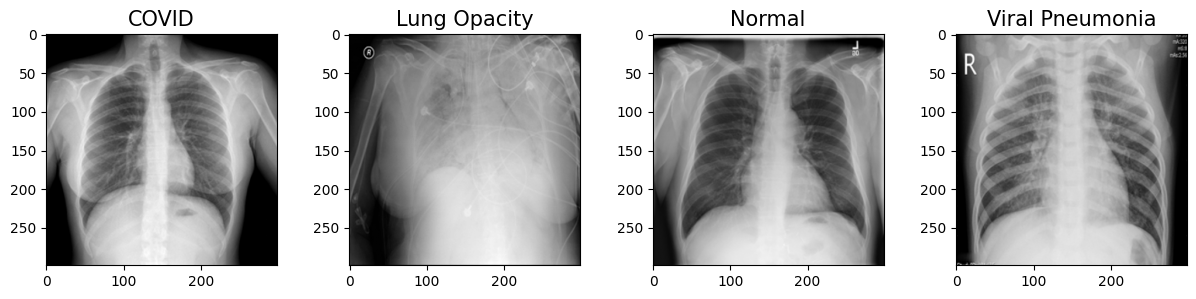

In [ ]:
# Create a dictionary that maps each label to a list of sample indices
label_to_idxs = defaultdict(list)

# Iterate over the dataset and collect indices for each label
for idx, sample in enumerate(sample_dataset.samples):
    label_to_idxs[sample["label"]].append(idx)

# Create a matplotlib figure with 1 row and 4 columns of subplots, set overall size
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

# For each axis and label (limit to first 4 labels), display a sample image
for ax, label in zip(axs, label_to_idxs.keys()):
    ax.set_title(label, fontsize=15)  # Set the title of the subplot to the label name

    # Choose a random sample index for the current label
    idx = random.choice(label_to_idxs[label])
    sample = sample_dataset[idx]  # Retrieve the actual sample

    print(sample)  # Print sample details (for inspection/debugging)

    image = sample["path"].squeeze()  # Extract the image and remove single-dimensional entries
    ax.imshow(image, cmap="gray")  # Display the image in grayscale


Finally, we will split the entire dataset into training, validation, and test sets using the ratios of 70%, 15%, and 15%, respectively. We will then obtain the corresponding data loaders for each set.

In [ ]:
# Define the expected input format for the dataset samples.
# "path" is a float tensor representing a grayscale image of size (1, 299, 299).
# "label" is a string, and its dimension is scalar (dim 0).
sample_dataset.input_info = {
    "path": {"type": float, "dim": (1, 299, 299)},
    "label": {"type": str, "dim": 0}
}

# Define the expected output format for the dataset samples.
# The model is expected to output a string label.
sample_dataset.output_info = {
    "label": {"type": str}
}

# Define a sequence of image preprocessing transformations using torchvision:
# - Convert to grayscale with 1 output channel,
# - Resize the image to 299x299 pixels,
# - Convert the image to a PyTorch tensor.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Define a custom dataset class inheriting from SampleBaseDataset.
class MyDataset(SampleBaseDataset):
    def __init__(self, samples, label_vocab=None):
        super().__init__(samples)

        # If no label-to-ID vocabulary is provided, create one from the unique labels in samples.
        if label_vocab is None:
            labels = sorted(set(sample["label"] for sample in samples))
            self.label_vocab = {label: i for i, label in enumerate(labels)}
        else:
            self.label_vocab = label_vocab

    def __getitem__(self, idx):
        sample = self.samples[idx].copy()

        # Open the image from disk, convert to grayscale ("L" mode), and apply transformations.
        image = Image.open(sample["path"]).convert("L")
        image = transform(image)
        sample["path"] = image  # Replace the file path with the transformed image tensor.

        # Convert the label string to its corresponding integer index as a tensor.
        sample["label"] = torch.tensor(self.label_vocab[sample["label"]], dtype=torch.long)

        # Add a "patient_id" field equal to the sample index.
        sample["patient_id"] = idx
        return sample

# Split the dataset into training (70%), validation (15%), and test (15%) subsets.
n_total = len(sample_dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

# Perform the split using random_split and store the raw subsets.
raw_train, raw_val, raw_test = random_split(sample_dataset, [n_train, n_val, n_test])

# Create instances of MyDataset for each subset using the corresponding sample indices.
# Use the same label vocabulary for all splits to ensure consistency.
train_dataset = MyDataset(samples=[sample_dataset.samples[i] for i in raw_train.indices])
val_dataset = MyDataset(samples=[sample_dataset.samples[i] for i in raw_val.indices], label_vocab=train_dataset.label_vocab)
test_dataset = MyDataset(samples=[sample_dataset.samples[i] for i in raw_test.indices], label_vocab=train_dataset.label_vocab)


## Step 3. Define the Model

Next, we will define the deep learning model we want to use for our task. PyHealth supports all major vision models available in the Torchvision package. You can load any of these models using the model_name argument.

In [ ]:
# Define a custom classifier class based on a pre-trained ResNet-18
class ResNetClassifier(BaseModel):
    def __init__(self, **kwargs):
        # Call the parent class initializer (BaseModel)
        super().__init__(**kwargs)
        # Load a pre-trained ResNet-18 model with default weights
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # We can put in here any model
        # Modify the first convolution layer to accept 1-channel (grayscale) images instead of 3-channel RGB
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def set_output_size(self, output_size):
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        # Replace the original classification head with a new linear layer to match the number of output classes
        self.resnet.fc = nn.Linear(num_ftrs, output_size)

    def forward(self, **kwargs):
        # Extract image tensor and labels from the input dictionary
        x = kwargs.get("path")
        labels = kwargs.get("label")

        # Forward pass through the ResNet model to get raw predictions (logits)
        logits = self.resnet(x)
        # Compute cross-entropy loss between predicted logits and true labels
        loss = F.cross_entropy(logits, labels)

        # Save true labels and predicted probabilities (after applying softmax)
        y_true = labels
        y_prob = F.softmax(logits, dim=1)

        # Return a dictionary with loss, logits, true labels, and predicted probabilities
        return {
            "loss": loss,
            "logits": logits,
            "y_true": y_true,
            "y_prob": y_prob
        }

# 6. Determine the number of classes from the training dataset's label vocabulary
num_classes = len(train_dataset.label_vocab)

# 7. Initialize the model with the training dataset, specifying the input and label keys and the type of task
model = ResNetClassifier(
    dataset=train_dataset,
    feature_keys=["path"],  # Input feature (image path/tensor)
    label_key="label",      # Target label
    mode="multiclass"       # Classification task with multiple classes
)

# Set the output layer of the model to match the number of classes
model.set_output_size(num_classes)



## Step 4. Training


In this step, we will train the model using PyHealth's Trainer class, which simplifies the training process and provides standard functionalities.

Let us first train the ResNet model.

Now, let's start the training process.

In [ ]:

# 8. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# 9. Initialisation of Trainer
trainer = Trainer(
    model=model,
    metrics=["accuracy"]
)

# 10. Start training with  DataLoaders
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    test_dataloader=test_loader,
    epochs=10,
    steps_per_epoch=32,
    optimizer_class=torch.optim.Adam,
    optimizer_params={"lr": 1e-4},
    load_best_model_at_last=True
)


ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

INFO:pyhealth.trainer:ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

Metrics: ['accuracy']


INFO:pyhealth.trainer:Metrics: ['accuracy']


Device: cpu


INFO:pyhealth.trainer:Device: cpu


INFO:pyhealth.trainer:


Training:


INFO:pyhealth.trainer:Training:


Batch size: 32


INFO:pyhealth.trainer:Batch size: 32


Optimizer: <class 'torch.optim.adam.Adam'>


INFO:pyhealth.trainer:Optimizer: <class 'torch.optim.adam.Adam'>


Optimizer params: {'lr': 0.0001}


INFO:pyhealth.trainer:Optimizer params: {'lr': 0.0001}


Weight decay: 0.0


INFO:pyhealth.trainer:Weight decay: 0.0


Max grad norm: None


INFO:pyhealth.trainer:Max grad norm: None


Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7a9ae0917b10>


INFO:pyhealth.trainer:Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7a9ae0917b10>


Monitor: None


INFO:pyhealth.trainer:Monitor: None


Monitor criterion: max


INFO:pyhealth.trainer:Monitor criterion: max


Epochs: 10


INFO:pyhealth.trainer:Epochs: 10


INFO:pyhealth.trainer:


Epoch 0 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-0, step-32 ---


INFO:pyhealth.trainer:--- Train epoch-0, step-32 ---


loss: 0.3394


INFO:pyhealth.trainer:loss: 0.3394
Evaluation: 100%|██████████| 100/100 [07:01<00:00,  4.21s/it]

--- Eval epoch-0, step-32 ---



INFO:pyhealth.trainer:--- Eval epoch-0, step-32 ---


accuracy: 0.8532


INFO:pyhealth.trainer:accuracy: 0.8532


loss: 0.3812


INFO:pyhealth.trainer:loss: 0.3812


INFO:pyhealth.trainer:


Epoch 1 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-1, step-64 ---


INFO:pyhealth.trainer:--- Train epoch-1, step-64 ---


loss: 0.3075


INFO:pyhealth.trainer:loss: 0.3075
Evaluation: 100%|██████████| 100/100 [07:02<00:00,  4.23s/it]

--- Eval epoch-1, step-64 ---



INFO:pyhealth.trainer:--- Eval epoch-1, step-64 ---


accuracy: 0.8812


INFO:pyhealth.trainer:accuracy: 0.8812


loss: 0.3148


INFO:pyhealth.trainer:loss: 0.3148


INFO:pyhealth.trainer:


Epoch 2 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-2, step-96 ---


INFO:pyhealth.trainer:--- Train epoch-2, step-96 ---


loss: 0.2670


INFO:pyhealth.trainer:loss: 0.2670
Evaluation: 100%|██████████| 100/100 [06:59<00:00,  4.20s/it]

--- Eval epoch-2, step-96 ---



INFO:pyhealth.trainer:--- Eval epoch-2, step-96 ---


accuracy: 0.8796


INFO:pyhealth.trainer:accuracy: 0.8796


loss: 0.3285


INFO:pyhealth.trainer:loss: 0.3285


INFO:pyhealth.trainer:


Epoch 3 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-3, step-128 ---


INFO:pyhealth.trainer:--- Train epoch-3, step-128 ---


loss: 0.2550


INFO:pyhealth.trainer:loss: 0.2550
Evaluation: 100%|██████████| 100/100 [06:59<00:00,  4.19s/it]

--- Eval epoch-3, step-128 ---



INFO:pyhealth.trainer:--- Eval epoch-3, step-128 ---


accuracy: 0.8715


INFO:pyhealth.trainer:accuracy: 0.8715


loss: 0.3518


INFO:pyhealth.trainer:loss: 0.3518


INFO:pyhealth.trainer:


Epoch 4 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-4, step-160 ---


INFO:pyhealth.trainer:--- Train epoch-4, step-160 ---


loss: 0.2389


INFO:pyhealth.trainer:loss: 0.2389
Evaluation: 100%|██████████| 100/100 [07:01<00:00,  4.21s/it]

--- Eval epoch-4, step-160 ---



INFO:pyhealth.trainer:--- Eval epoch-4, step-160 ---


accuracy: 0.8919


INFO:pyhealth.trainer:accuracy: 0.8919


loss: 0.3031


INFO:pyhealth.trainer:loss: 0.3031


INFO:pyhealth.trainer:


Epoch 5 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-5, step-192 ---


INFO:pyhealth.trainer:--- Train epoch-5, step-192 ---


loss: 0.2520


INFO:pyhealth.trainer:loss: 0.2520
Evaluation: 100%|██████████| 100/100 [07:01<00:00,  4.22s/it]

--- Eval epoch-5, step-192 ---



INFO:pyhealth.trainer:--- Eval epoch-5, step-192 ---


accuracy: 0.9080


INFO:pyhealth.trainer:accuracy: 0.9080


loss: 0.2741


INFO:pyhealth.trainer:loss: 0.2741


INFO:pyhealth.trainer:


Epoch 6 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-6, step-224 ---


INFO:pyhealth.trainer:--- Train epoch-6, step-224 ---


loss: 0.2837


INFO:pyhealth.trainer:loss: 0.2837
Evaluation: 100%|██████████| 100/100 [07:02<00:00,  4.23s/it]

--- Eval epoch-6, step-224 ---



INFO:pyhealth.trainer:--- Eval epoch-6, step-224 ---


accuracy: 0.9156


INFO:pyhealth.trainer:accuracy: 0.9156


loss: 0.2319


INFO:pyhealth.trainer:loss: 0.2319


INFO:pyhealth.trainer:


Epoch 7 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-7, step-256 ---


INFO:pyhealth.trainer:--- Train epoch-7, step-256 ---


loss: 0.2541


INFO:pyhealth.trainer:loss: 0.2541
Evaluation: 100%|██████████| 100/100 [07:02<00:00,  4.23s/it]

--- Eval epoch-7, step-256 ---



INFO:pyhealth.trainer:--- Eval epoch-7, step-256 ---


accuracy: 0.9241


INFO:pyhealth.trainer:accuracy: 0.9241


loss: 0.2165


INFO:pyhealth.trainer:loss: 0.2165


INFO:pyhealth.trainer:


Epoch 8 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-8, step-288 ---


INFO:pyhealth.trainer:--- Train epoch-8, step-288 ---


loss: 0.2388


INFO:pyhealth.trainer:loss: 0.2388
Evaluation: 100%|██████████| 100/100 [07:03<00:00,  4.23s/it]

--- Eval epoch-8, step-288 ---



INFO:pyhealth.trainer:--- Eval epoch-8, step-288 ---


accuracy: 0.8828


INFO:pyhealth.trainer:accuracy: 0.8828


loss: 0.3462


INFO:pyhealth.trainer:loss: 0.3462


INFO:pyhealth.trainer:


Epoch 9 / 10:   0%|          | 0/32 [00:00<?, ?it/s]

--- Train epoch-9, step-320 ---


INFO:pyhealth.trainer:--- Train epoch-9, step-320 ---


loss: 0.2636


INFO:pyhealth.trainer:loss: 0.2636
Evaluation: 100%|██████████| 100/100 [07:03<00:00,  4.24s/it]

--- Eval epoch-9, step-320 ---



INFO:pyhealth.trainer:--- Eval epoch-9, step-320 ---


accuracy: 0.9001


INFO:pyhealth.trainer:accuracy: 0.9001


loss: 0.2822


INFO:pyhealth.trainer:loss: 0.2822
Evaluation: 100%|██████████| 100/100 [07:04<00:00,  4.25s/it]

--- Test ---



INFO:pyhealth.trainer:--- Test ---


accuracy: 0.8929


INFO:pyhealth.trainer:accuracy: 0.8929


loss: 0.2858


INFO:pyhealth.trainer:loss: 0.2858


## Step 5. Evaluation

Lastly, we can eavluate the ResNet model on the test set. This can be done using PyHealth's `Trainer.evaluate()` function.

In [ ]:

# 11. Evaluation on test
results = trainer.evaluate(test_loader)
print("Test Results:", results)

Evaluation: 100%|██████████| 100/100 [07:00<00:00,  4.21s/it]

Test Results: {'accuracy': 0.8929471032745592, 'loss': 0.2857769752293825}


Additionally, you can perform inference using the `Trainer.inference()` function.

In [ ]:
# Run inference on the test data using the trainer object.
# The method returns:
# - y_true: the true labels for the test samples
# - y_prob: the predicted class probabilities from the model
# - loss: the overall loss calculated during inference
# - patient_id: the identifiers for each patient/sample
y_true, y_prob, loss, patient_id = trainer.inference(test_loader, return_patient_ids=True)

# Convert predicted probabilities to class predictions by taking the index of the highest probability (argmax)
y_pred = y_prob.argmax(axis=1)


Evaluation: 100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


Below we show a confusion matrix of the trained ResNet model.

Text(50.722222222222214, 0.5, 'True')

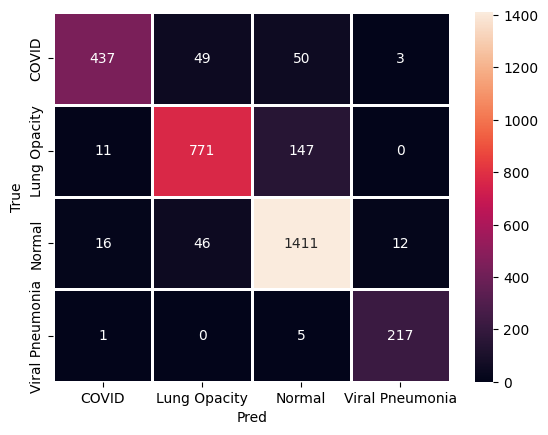

In [ ]:
# Compute the confusion matrix using true and predicted labels
cf_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap from the confusion matrix with grid lines and numeric annotations
ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')

# Set x-axis tick labels using label names (converted from IDs for 4 classes)
ax.set_xticklabels([id2label[i] for i in range(4)])

# Set y-axis tick labels using label names (converted from IDs for 4 classes)
ax.set_yticklabels([id2label[i] for i in range(4)])

# Label the x-axis as "Pred" to indicate predicted values
ax.set_xlabel("Pred")

# Label the y-axis as "True" to indicate true labels
ax.set_ylabel("True")


##Sammory

Accuracy: 89.3%
Almost 9 out of 10 predictions are correct.

This is a good value for multi-class classification of medical images.

Loss: ~0.29
Relatively low loss indicates that the model is confident in its predictions.

However, accuracy is not perfect, which may mean:

Either uneven confidence across classes,

Or insufficient sensitivity to some pathologies (as can be seen from the confusion matrix - COVID and Lung Opacity are confused).

The confusion matrix provides the following conclusions about the quality of the chest X-ray classification model:

General structure:
Axes:

Vertical — True labels

Horizontal — Predicted labels

The color of the cells and the numbers in them show the number of cases for each combination of the true and predicted class.

Brief analysis by class:
Normal:
1411 out of 1485 predictions are correct (very high accuracy).

The model distinguishes normal images well.

COVID:
437 correct, but 49 + 50 are confused with Lung Opacity and Normal.

There is a noticeable overlap with other pathologies — the model sometimes confuses COVID with other classes.

Lung Opacity:
771 correct out of 929. Errors on Normal (147) — the model does not always confidently distinguish from a healthy state.

Viral Pneumonia:
Almost perfect recognition: 217 correct, only 6 errors.

The class is distinguished confidently.

Overall rating:
Strengths:

Excellent prediction of Normal and Viral Pneumonia.

The overall structure shows that the model is well trained.

Weaknesses:

COVID and Lung Opacity are often confused with each other and with the norm - requires improvement of features/architecture.

There may be problems with unbalanced data or similar visual features.

Recommendations:
Check the class balancing in the training set.

Refine image preprocessing.

Try to enhance COVID features (e.g. using attention mechanisms or increasing the sample).

Accuracy (точность): 89.3%
Почти 9 из 10 предсказаний — верны.

Это хорошее значение для многоклассовой классификации медицинских изображений.

Loss (потери): ~0.29
Относительно низкий loss указывает на то, что модель уверена в своих предсказаниях.

Однако при этом accuracy не идеален, что может означать:

Либо неравномерная уверенность по классам,

Либо недостаточная чувствительность к некоторым патологиям (как видно из матрицы ошибок — COVID и Lung Opacity путаются).

По матрице ошибок (confusion matrix) можно сделать следующие выводы о качестве модели классификации снимков грудной клетки:

 Общая структура:
Оси:

Вертикаль — истинные метки (True labels)

Горизонталь — предсказанные метки (Pred labels)

Цвет ячеек и числа в них показывают количество случаев для каждой комбинации истинного и предсказанного класса.

 Краткий анализ по классам:
 Normal (Норма):
1411 из 1485 предсказаний — верны (очень высокая точность).

Модель хорошо различает нормальные снимки.

 COVID:
437 правильных, но 49 + 50 перепутаны с Lung Opacity и Normal.

Есть заметное пересечение с другими патологиями — модель иногда путает COVID с другими классами.

 Lung Opacity:
771 правильных из 929. Ошибки на Normal (147) — модель не всегда уверенно отличает от здорового состояния.

 Viral Pneumonia:
Почти идеальное распознавание: 217 правильных, всего 6 ошибок.

Класс различается уверенно.

 Общая оценка:
Сильные стороны:

Отлично предсказывает Normal и Viral Pneumonia.

Общая структура показывает хорошую обученность модели.

Слабые стороны:

COVID и Lung Opacity часто путаются между собой и с нормой — требует доработки признаков/архитектуры.

Возможны проблемы с несбалансированными данными или близкими визуальными признаками.

 Рекомендации:
Проверить балансировку классов в обучающей выборке.

Уточнить предобработку изображений.

Попробовать усилить признаки COVID (например, с помощью attention-механизмов или увеличения выборки).

In [ ]:
# Save the current state (checkpoint) of the model trainer to a file
# The checkpoint includes model weights, optimizer state, and potentially other training info
# This allows training to be resumed later or the model to be used for inference
trainer.save_ckpt("./ChestXrayClassification_model_checkpoint.pth")
